## Modelo Basedo em Chamadas Chat+Prompt

In [6]:
import openai
import tqdm
import json
import pandas as pd
#
from matplotlib.colors import LinearSegmentedColormap
colors = [(0, 1, 0), (1, 0, 0)]  # Verde para vermelho
cmap = LinearSegmentedColormap.from_list('CustomCmap', colors, N=100)
#
from matplotlib import pyplot as plt
import seaborn as sns


## Funções Auxiliares

In [2]:
import numpy as np

def calculate_mse(predictions, actual_values):
    mse = np.mean((predictions - actual_values) ** 2)
    return mse


## Carrega Dados

In [7]:
dataframe = pd.read_csv('../data/base_redacoes_final.csv')
dataframe = dataframe.rename(columns={'nota_final':'nota_real'})

## Prompt

In [10]:
def make_exemplo(nota_alta):
    if nota_alta:
        ex = dataframe[dataframe.nota_real == 1000].iloc[0]
    else:
        ex = dataframe[dataframe.nota_real < 500].iloc[0]

    return f'''Segue um exemplo de uma redação para o tema ""{ex.tema}"" com o título ""{ex.titulo}"" e as notas que deveriam ser atribuídas a ela:
    Texto: ""{ex.texto_original}""
    criterio_1: ""{ex.comp_lingua_culta}"",
    criterio_2: ""{ex.comp_proposta}"",
    criterio_3: ""{ex.comp_argumentacao}"",
    criterio_4: ""{ex.comp_conhecimentos}"",
    criterio_5: ""{ex.comp_proposta_solucao}"",
    avaliacao_geral: "{ex.comentario_geral}",
    nota_atribuida: {ex.nota_real}
    '''

In [28]:
openai.api_key = os.environ['OPENAPI_KEY']

def make_request(row):
    global output
    redacao = row.texto_original
    tema = row.tema
    titulo = row.titulo

    CRITERIO_1 = "Demonstrar domínio da norma culta da língua escrita."
    CRITERIO_2 = "Compreender a proposta da redação e aplicar conceito das várias áreas de conhecimento para desenvolver o tema, dentro dos limites estruturais do texto dissertativo-argumentativo."
    CRITERIO_3 = "Selecionar, relacionar, organizar e interpretar informações, fatos, opiniões e argumentos em defesa de um ponto de vista."
    CRITERIO_4 = "Demonstrar conhecimento dos mecanismos linguísticos necessários para a construção da argumentação."
    CRITERIO_5 = "Elaborar a proposta de solução para o problema abordado, mostrando respeito aos valores humanos e considerando a diversidade sociocultura"

    CRITERIO_1_NOTA = """200 pontos: Excelente domínio da escrita formal da língua portuguesa.
    160 pontos: Bom domínio da escrita formal com poucos desvios gramaticais.
    120 pontos: Domínio mediano da escrita formal, com alguns desvios gramaticais.
    80 pontos: Domínio insuficiente da escrita formal com muitos desvios gramaticais.
    40 pontos: Domínio precário da escrita formal d com diversificados e frequentes desvios gramaticais.
    0 pontos: Desconhecimento da  escrita formal da língua portuguesa."""
    CRITERIO_2_NOTA = """200 pontos:Argumentação consistente, a partir de um repertório sociocultural produtivo e apresenta excelente dominio do texto dissertativo-argumentativo.
    160 pontos: Argumentação consistente e apresenta bom domínio do texto dissertativo-argumentativo, com parágrafos de proposição, argumentação e conclusão.
    120 pontos: Argumentação previsível e apresenta domínio mediano do texto dissertativo-argumentativo, com parágrafos de  proposição, argumentação e conclusão.
    80 pontos: Apresenta domínio insuficiente do texto dissertativo-argumentativo, não atendendo à estrutura com parágrafos de  proposição, argumentação e conclusão. 
    40 pontos: Apresenta o assunto, tangenciando o tema, ou demonstra dominio precário do texto dissertativo-argumentativo, com traços constantes de outros tipos textuais. 
    O pontos: Fuga ao tema/não atendimento à estrutura dissertativo-argumentativa"""
    CRITERIO_3_NOTA = """200 pontos: Apresenta informações, fatos e opiniões relacionados ao tema proposto, de forma consistente e organizada, configurando autoria em defesa de um ponto de vista.
    160 pontos: Informações relacionados ao tema, de forma organizada, com indícios de autoria, em defesa de um ponto de vista.
    120 pontos: informações relacionados ao tema, limitados aos argumentos dos textos motivadores e pouco organizados.
    80 pontos: informações relacionados ao tema, mas desorganizados ou contraditórios e limitados aos argumentos dos textos motivadores.
    40 pontos: informações pouco relacionados ao tema ou incoerentes e sem defesa de um ponto de vista. 
    O pontos: informações, fatos e opioniões não relacionadas ao tema e sem defesa de um ponto de vista"""
    CRITERIO_4_NOTA = """200 pontos: Articula bem as partes do texto e apresenta repertório diversificado de recursos coesivos.
    160 pontos: Articula as partes do texto, com poucas inaquações, e apresenta repertório diversificado de recursos coesivos.
    120 pontos: Articula as partes do texto, de forma mediana, com inadequações, e apresenta repertório pouco diversificado de recursos coesivos.
    80 pontos:Articula as partes do texto, de forma insuficiente, com muitas inaqueações e apresenta repertório limitado de recursos coesivos. 
    40 pontos: Articula as partes do texto de forma precária. 
    O pontos: Não articula as informações."""
    CRITERIO_5_NOTA = """200 pontos: Elabora muito bem proposta de intervenção, detalhada, relacionada ao tema e artivulada à discussão desenvolvida no texto.
    160 pontos: Elabora bem proposta de intervenção relacionada ao tema e articula à discussão desenvolvida no texto.
    120 pontos: Elabora, de forma mediana, proposta de intervenção relacionada ao tema e articulada à discussão desenvolvida no texto.
    80 pontos: Elabora, de forma insuficiente, proposta de intervenção relacionada ao tema, ou não articulada com a discussão desenvolvida no texto. 
    40 pontos: Apresenta proposta de intervenção vaga, precária ou relacionada apenas ao assunto. 
    O pontos: Não apresenta proposta de intervenção ou apresenta proposta não relacionada ao tema ou ao assunto."""

    CONTEXTO = f'''
    Você é um avaliador de redações e irá pontuar uma redação do assunto {tema} considerando os critérios:
            CRITÉRIO 1. {CRITERIO_1}
            CRITÉRIO 2. {CRITERIO_2}
            CRITÉRIO 3. {CRITERIO_3}
            CRITÉRIO 4. {CRITERIO_4} 
            CRITÉRIO 5. {CRITERIO_5}
            Para cada critério deve ser dada uma nota de 0 a 200, junto com uma descrição do motivo dessa nota.'''
    ENTRADA_REDACAO = f'''O tema da redação é "{tema}" e o escritor deu o título de "{titulo}". Esta é a redação: 
    """{redacao}"""
    '''
    FORMATO_DE_SAIDA = '''A saída deve ser no formato JSON. Não usando aspas duplas no conteúdo dos campos:
        {
            "criterio_1":(nota, detalhes),
            "criterio_2":(nota, detalhes),
            "criterio_3":(nota, detalhes),
            "criterio_4":(nota, detalhes),
            "criterio_5":(nota, detalhes),
            "avaliacao_geral": "cometários gerais sobre o texto",
            "nota_atribuida": "soma das notas dos critérios"
        }'''
    messages = [{"role": "system", "content": CONTEXTO},
                {"role": "user", "content": ENTRADA_REDACAO + FORMATO_DE_SAIDA},
                ]
    #
    #
    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=messages,
        temperature=0.4,
        max_tokens=1000,
    )
    output = response.choices[0].message['content'].strip()
    output = eval(output)
    return output


## Chamada

In [29]:
openai.api_key = os.environ['OPENAPI_KEY']

resultado_consulta = []
for i in tqdm.tqdm(range(100)):
    row = dataframe.iloc[i]
    result = make_request(row)
    for col in dataframe.columns:
        result[col] = row[col]
    resultado_consulta.append(result)

100%|██████████| 100/100 [17:43<00:00, 10.64s/it]


resultado_consulta

## Avaliação

In [36]:
# Join da base com o resultado
result_df = pd.DataFrame(resultado_consulta)
result_df['criterio_1_nota'] = [t[0] for t in result_df.criterio_1]
result_df['criterio_2_nota'] = [t[0] for t in result_df.criterio_2]
result_df['criterio_3_nota'] = [t[0] for t in result_df.criterio_3]
result_df['criterio_4_nota'] = [t[0] for t in result_df.criterio_4]
result_df['criterio_5_nota'] = [t[0] for t in result_df.criterio_5]
result_df = result_df.dropna()
result_df['nota_atribuida'] = result_df['nota_atribuida'].astype(int)
result_df['nota_real'] = result_df['nota_real'].astype(int)
#
result_df[['nota_atribuida','nota_real']].head(3)

,nota_atribuida,nota_real
0,550,480
1,300,220
2,600,400


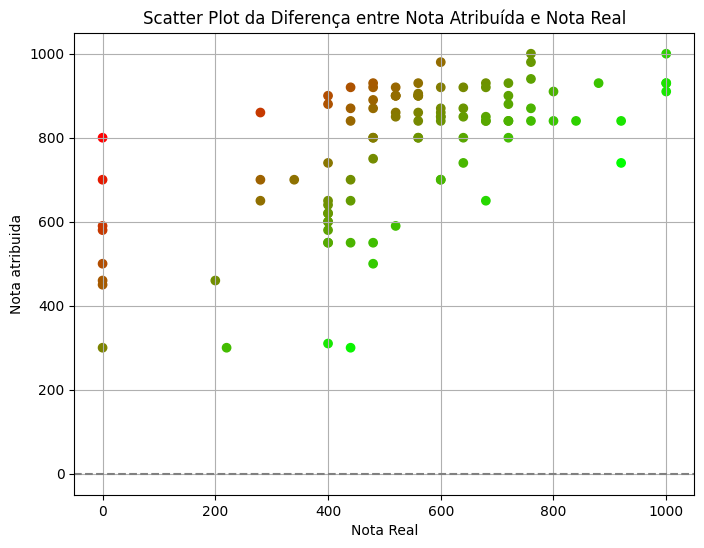

In [31]:

# Calcular a diferença entre as colunas
result_df['diferenca'] = result_df['nota_atribuida'] - result_df['nota_real']

# Configuração do gráfico
plt.figure(figsize=(8, 6))
plt.scatter(result_df['nota_real'], result_df['nota_atribuida'], cmap=cmap, marker='o', c=result_df['diferenca'],)
plt.axhline(0, color='gray', linestyle='--')  # Linha horizontal em y=0
plt.xlabel('Nota Real')
plt.ylabel('Nota atribuida')
plt.title('Scatter Plot da Diferença entre Nota Atribuída e Nota Real')
plt.grid(True)

plt.show()

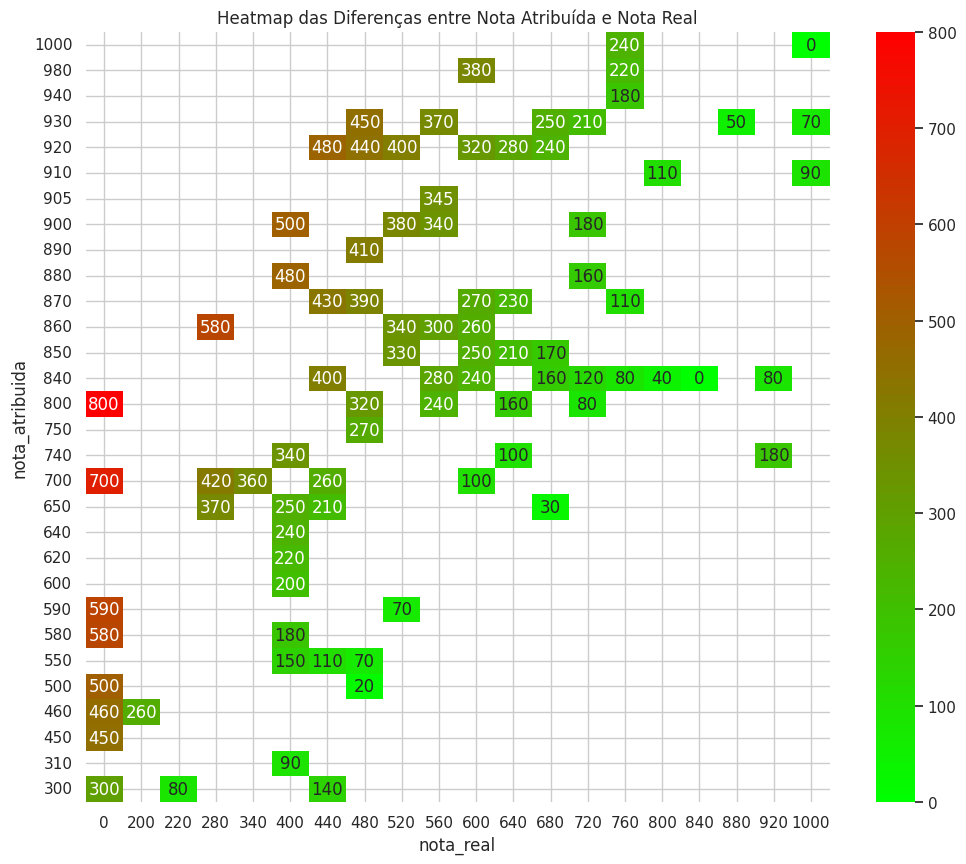

In [32]:
# Calcular a diferença entre as colunas
result_df['diferenca'] = abs(result_df['nota_atribuida'] - result_df['nota_real'])

# Criar um heatmap
sns.set(style="whitegrid")
plt.figure(figsize=(12, 10))
heatmap_data = result_df.pivot_table(index='nota_atribuida', columns='nota_real', values='diferenca').sort_index(ascending=False)
sns.heatmap(heatmap_data, annot=True, cmap=cmap, fmt=".0f")

plt.title('Heatmap das Diferenças entre Nota Atribuída e Nota Real')
plt.show()

In [33]:
corr = result_df['nota_atribuida'].corr(result_df['nota_real'])
mean  = result_df['diferenca'].mean()
MSE = calculate_mse(result_df['nota_atribuida'].values, result_df['nota_real'].values)
print(f'Correlação entre as notas reais e as atribuída pelo modelo: {corr:.4}')
print(f'Diferença média entre as notas reais e as atribuída pelo modelo: {int(mean)}')
print(f'MSE dos erros: {int(MSE)}')


Correlação entre as notas reais e as atribuída pelo modelo: 0.6346
Diferença média entre as notas reais e as atribuída pelo modelo: 260
MSE dos erros: 91963


#### Métrica

In [142]:
result_df.columns

Index(['criterio_1', 'criterio_2', 'criterio_3', 'criterio_4', 'criterio_5',
       'avaliacao_geral', 'nota_atribuida', 'tema', 'titulo', 'nota_real',
       'comp_lingua_culta', 'comp_proposta', 'comp_argumentacao',
       'comp_conhecimentos', 'comp_proposta_solucao', 'url', 'texto_original',
       'texto_corrigido', 'comentario_geral', 'criterio_1_nota',
       'criterio_2_nota', 'criterio_3_nota', 'criterio_4_nota',
       'criterio_5_nota', 'diferenca'],
      dtype='object')

In [144]:
corr = result_df['criterio_3_nota'].corr(result_df['comp_argumentacao'])
mean  = result_df['diferenca'].mean()
MSE = calculate_mse(result_df['criterio_3_nota'].values, result_df['comp_argumentacao'].values)
print(f'Correlação entre as notas reais e as atribuída pelo modelo: {corr:.4}')
print(f'Diferença média entre as notas reais e as atribuída pelo modelo: {int(mean)}')
print(f'MSE dos erros: {int(MSE)}')


Correlação entre as notas reais e as atribuída pelo modelo: 0.4837
Diferença média entre as notas reais e as atribuída pelo modelo: 244
MSE dos erros: 3944
